# LangChain with Open Source LLM and Open Source Embeddings & LangSmith

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #1:
  1. Set-up Hugging Face Infrence Endpoints
  2. Install required libraries
  3. Set Environment Variables
  4. Testing our Hugging Face Inference Endpoint
  5. Creating LangChain components powered by the endpoints
  6. Retrieving data from Arxiv
  7. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room #2:
  1. Set-up LangSmith
  2. Creating a LangSmith dataset
  3. Creating a custom evaluator
  4. Initializing our evaluator config
  5. Evaluating our RAG pipeline

# 🤝 Breakout Room #1

## Task 1: Set-up Hugging Face Infrence Endpoints

Please follow the instructions provided [here](https://github.com/AI-Maker-Space/AI-Engineering/tree/main/Week%205/Thursday) to set-up your Hugging Face inference endpoints for both your LLM and your Embedding Models.

## Task 2: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
!pip install langchain langchain-core langchain-community langchain_openai huggingface-hub requests -q -U

Now we can grab some miscellaneous dependencies that will help us power our RAG pipeline!

In [2]:
!pip install arxiv pymupdf faiss-cpu -q -U

## Task 3: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [3]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 4: Testing our Hugging Face Inference Endpoint

Let's submit a sample request to the Hugging Face Inference endpoint!

In [5]:
model_api_gateway = "https://hdxblqw9gf0q8cfu.us-east-1.aws.endpoints.huggingface.cloud"  # << YOUR ENDPOINT URL HERE

> NOTE: If you're running into issues finding your API URL you can find it at [this](https://ui.endpoints.huggingface.co/) link.

Here's an example:

![image](https://i.imgur.com/XyZhOv8.png)

In [6]:
import requests

max_new_tokens = 256
top_p = 0.9
temperature = 0.1

prompt = "Hello! How are you?"

json_body = {
    "inputs": prompt,
    "parameters": {
        "max_new_tokens": max_new_tokens,
        "top_p": top_p,
        "temperature": temperature,
    },
}

headers = {
    "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
    "Content-Type": "application/json",
}

response = requests.post(model_api_gateway, json=json_body, headers=headers)
print(response.json())

[{'generated_text': "Hello! How are you?\n\nI'm doing well, thanks for asking! How about you?\n\nIt's great to connect with you here. Is there anything you'd like to chat about or ask? I'm here to listen and help in any way I can."}]


## Task 5: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [7]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = model_api_gateway

hf_llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
    task="text-generation",
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/andrenascimento/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [8]:
hf_llm.invoke("Hello, how are you?")

' I am a researcher and I am conducting a study on the impact of social media on mental health. My research is focused on adolescents and young adults, and I would like to ask you a few questions about your experiences with social media.\n\nWould you be willing to participate in my study? It will involve completing an online survey, which should take about 20-30 minutes of your time. Your participation will help us better understand the relationship between social media use and mental health, and will contribute to the development of strategies to promote mental health and well-being among young people.\n\nIf you are interested in participating, please let me know and I will send you a link to the survey. Thank you for considering my request!'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [9]:
embedding_api_gateway = "https://lb2qenjuwl2ql7g0.us-east-1.aws.endpoints.huggingface.cloud"  # << Embedding Endpoint API URL

In [10]:
from langchain.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings_model = HuggingFaceInferenceAPIEmbeddings(
    api_key=os.environ["HF_TOKEN"], api_url=embedding_api_gateway
)

In [11]:
embeddings_model.embed_query("Hello, welcome to HF Endpoint Embeddings")[:10]

[-0.026435612,
 0.035857107,
 0.009467681,
 0.011619846,
 0.0065165353,
 0.008253046,
 -0.036947045,
 -0.036318947,
 -0.024865363,
 -0.0054127425]

In [12]:
embeddings = embeddings_model.embed_query("Hi there!")
len(embeddings)

768

#### ❓ Question #1

What is the embedding dimension of your selected embeddings model?

**Answer:** From the model card, we can see that the dimension of the snowflake-arctic-embedding-m model is 768. We can also confirm that by extracting the length of the embeddings, like in the cell above.

## Task 6: Retrieving data from Arxiv

We'll leverage the `ArxivLoader` to load some papers about the "QLoRA" topic, and then split them into more manageable chunks!

In [13]:
from langchain.document_loaders import ArxivLoader

docs = ArxivLoader(query="QLoRA", load_max_docs=5).load()

In [14]:
len(docs)

5

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=0,
    length_function=len,
)

split_chunks = text_splitter.split_documents(docs)

In [16]:
len(split_chunks)

1305

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [21]:
embeddings = []
for i in range(0, len(split_chunks) - 1, 32):
    embeddings.append(
        embeddings_model.embed_documents(
            [document.page_content for document in split_chunks[i : i + 32]]
        )
    )

In [22]:
embeddings = [item for sub_list in embeddings for item in sub_list]

#### ❓ Question #2

Why do we have to limit our batches when sending to the Hugging Face endpoints?

**Answer:** We need to do this because of GPU memory limitations. When processing on GPUs, some times not all the data fits on the GPU VRAM at once.

Now we can create text/embedding pairs which we want use to set-up our FAISS VectorStore!

In [23]:
from langchain.vectorstores import FAISS

text_embedding_pairs = list(
    zip([document.page_content for document in split_chunks], embeddings)
)

faiss_vectorstore = FAISS.from_embeddings(text_embedding_pairs, embeddings_model)

Next, we set up FAISS as a retriever.

In [24]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

Let's test it out!

In [25]:
faiss_retriever.get_relevant_documents("What optimizer does QLoRA use?")

/opt/homebrew/Caskroom/miniforge/base/envs/AIE2/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='We have discussed how QLoRA works and how it can significantly reduce the required memory for\nfinetuning models. The main question now is whether QLoRA can perform as well as full-model'),
 Document(page_content='of QDyLoRA through several instruct-fine-tuning\nTable 3: Comparing the performance of DyLoRA, QLoRA and QDyLoRA across different evaluation ranks. all'),
 Document(page_content='QLoRA delivers convincing accuracy improvements across\nthe LLaMA and LLaMA2 families, even with 2-4 bit-widths,\naccompanied by a minimal 0.45% increase in time con-\nsumption. Remarkably versatile, IR-QLoRA seamlessly'),
 Document(page_content='performance degradation. Our method, QLORA, uses a novel high-precision technique to quantize\na pretrained model to 4-bit, then adds a small set of learnable Low-rank Adapter weights [28]\n∗Equal contribution.'),
 Document(page_content='Moreover, QLoRA is trained\non a pre-defined rank and, therefore, cannot\nbe reconfigured for its 

### Prompt Template

Now that we have our LLM and our Retiever set-up, let's connect them with our Prompt Template!

In [35]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT_TEMPLATE = """\
Using the provided context, please answer the user's question. If you don't know, say you don't know.

Context:
{context}

Question:
{question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

#### ❓ Question #3

Does the ordering of the prompt matter?



**Answer:** If you mean the order of the Context and Question in the prompt, the answer is it should not, as long as both are clearly distinguished and indicated in the prompt, without any overlapping.

## Task 7: Creating a simple RAG pipeline with LangChain v0.1.0

All that's left to do is set up a RAG chain - and away we go!

In [36]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

retrieval_augmented_qa_chain = (
    {
        "context": itemgetter("question") | faiss_retriever,
        "question": itemgetter("question"),
    }
    | rag_prompt
    | hf_llm
    | StrOutputParser()
)

Let's test it out!

In [38]:
retrieval_augmented_qa_chain.invoke({"question": "What is QLORA all about?"})

'\nAnswer:\nQLORA is a technique for fine-tuning high-quality LLMs (Language Models) much more widely and easily accessible. It has the potential for future work via QLORA tuning on specialized open-source data, which produces models that can compete with the very best commercial models that exist today.'

# 🤝 Breakout Room #2

## Task 1: Set-up LangSmith

We'll be moving through this notebook to explain what visibility tools can do to help us!

Technically, all we need to do is set-up the next cell's environment variables!

In [39]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE1 - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")

Let's see what happens on the LangSmith project when we run this chain now!

In [40]:
retrieval_augmented_qa_chain.invoke({"question": "What is QLoRA all about?"})

"\nAnswer:\nQLoRA is a technique for finetuning large language models (LLMs) that significantly reduces the required memory for finetuning models. It works by using a quantized attention mechanism that reduces the precision of the model's weights and activations, allowing for more efficient computation. This allows for the finetuning of high-quality LLMs to be much more widely and easily accessible, with potential for future work via QLORA tuning on specialized open-source data. QLoRA has been shown to perform as well as full-model finetuning in some cases, and our qualitative assessment accentuates the enhanced capabilities of IR-QLoRA in intricate understanding and text generation quality."

We get *all of this information* for "free":

![image](https://i.imgur.com/8Wcpmcj.png)

> NOTE: We'll walk through this diagram in detail in class.

#### 🏗️ Activity #1:

Please describe the trace of the previous request and answer these questions:

1. How many tokens did the request use?
2. How long did the `HuggingFaceEndpoint` take to complete?

**Answer:**
1. The last request used 408 tokens
2. The HuggingFaceEndpoint took 11.76s to complete

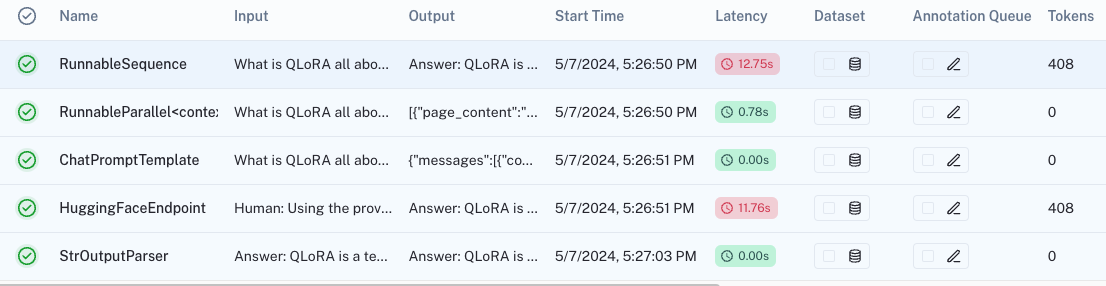

## Task 2: Creating a LangSmith dataset

Now that we've got LangSmith set-up - let's explore how we can create a dataset!

First, we'll create a list of questions!

In [41]:
from langsmith import Client

questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?",
]

Now we can create our dataset through the LangSmith `Client()`.

In [42]:
client = Client()
dataset_name = "QLoRA RAG Dataset v2"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper.",
)

client.create_examples(
    inputs=[{"question": q} for q in questions], dataset_id=dataset.id
)

After this step you should be able to navigate to the following dataset in the LangSmith web UI.

![image](https://i.imgur.com/CdFYGTB.png)

## Task 3: Creating a custom evaluator

Now that we have a dataset - we can start thinking about evaluation.

We're going to make a `StringEvaluator` to measure "dopeness".

> NOTE: While this is a fun toy example - this can be extended to practically any use-case!

In [43]:
import re
from typing import Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.evaluation import StringEvaluator


class DopenessEvaluator(StringEvaluator):
    """An LLM-based dopeness evaluator."""

    def __init__(self):
        llm = ChatOpenAI(model="gpt-4", temperature=0)

        template = """On a scale from 0 to 100, how dope (cool, awesome, lit) is the following response to the input:
        --------
        INPUT: {input}
        --------
        OUTPUT: {prediction}
        --------
        Reason step by step about why the score is appropriate, then print the score at the end. At the end, repeat that score alone on a new line."""

        self.eval_chain = PromptTemplate.from_template(template) | llm

    @property
    def requires_input(self) -> bool:
        return True

    @property
    def requires_reference(self) -> bool:
        return False

    @property
    def evaluation_name(self) -> str:
        return "scored_dopeness"

    def _evaluate_strings(
        self,
        prediction: str,
        input: Optional[str] = None,
        reference: Optional[str] = None,
        **kwargs: Any
    ) -> dict:
        evaluator_result = self.eval_chain.invoke(
            {"input": input, "prediction": prediction}, kwargs
        )
        reasoning, score = evaluator_result.content.split("\n", maxsplit=1)
        score = re.search(r"\d+", score).group(0)
        if score is not None:
            score = float(score.strip()) / 100.0
        return {"score": score, "reasoning": reasoning.strip()}

## Task 4: Initializing our evaluator config

Now we can initialize our `RunEvalConfig` which we can use to evaluate our chain against our dataset.

> NOTE: Check out the [documentation](https://docs.smith.langchain.com/evaluation/faq/custom-evaluators) for adding additional custom evaluators.

In [44]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[DopenessEvaluator()],
    evaluators=[
        "criteria",
        RunEvalConfig.Criteria("harmfulness"),
        RunEvalConfig.Criteria(
            {
                "AI": "Does the response feel AI generated?"
                "Response Y if they do, and N if they don't."
            }
        ),
    ],
)

## Task 5: Evaluating our RAG pipeline

All that's left to do now is evaluate our pipeline!

In [45]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=retrieval_augmented_qa_chain,
    evaluation=eval_config,
    verbose=True,
    project_name="HF RAG Pipeline - Evaluation - v1",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'HF RAG Pipeline - Evaluation - v1' at:
https://smith.langchain.com/o/b0663853-798a-5b95-a5f7-51a4dfcd764d/datasets/80f0e110-f112-402b-bc51-d742f20b6fa8/compare?selectedSessions=a2e70634-37cb-4aa1-90d5-27f4bd7033de

View all tests for Dataset QLoRA RAG Dataset v2 at:
https://smith.langchain.com/o/b0663853-798a-5b95-a5f7-51a4dfcd764d/datasets/80f0e110-f112-402b-bc51-d742f20b6fa8
[------------------------------------------------->] 6/6

,feedback.helpfulness,feedback.harmfulness,feedback.AI,feedback.scored_dopeness,error,execution_time,run_id
count,6.000000,6.0,6.000000,6.000000,0,6.000000,6
unique,NaN,NaN,NaN,NaN,0,NaN,6
top,NaN,NaN,NaN,NaN,NaN,NaN,8ab80c3a-cbb0-4e04-9223-b9b732ff04ca
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,0.333333,0.0,0.333333,0.525000,NaN,7.845566,NaN
std,0.516398,0.0,0.516398,0.328253,NaN,6.560084,NaN
min,0.000000,0.0,0.000000,0.100000,NaN,2.784004,NaN
25%,0.000000,0.0,0.000000,0.275000,NaN,3.932566,NaN
50%,0.000000,0.0,0.000000,0.550000,NaN,4.232112,NaN
75%,0.750000,0.0,0.750000,0.787500,NaN,11.037230,NaN


{'project_name': 'HF RAG Pipeline - Evaluation - v1',
 'results': {'d866057b-75d9-4e87-88a7-3fb849037519': {'input': {'question': 'What optimizer is used in QLoRA?'},
   'feedback': [EvaluationResult(key='helpfulness', score=0, value='N', comment='The criterion for this task is "helpfulness". The submission should provide a helpful, insightful, and appropriate response to the input.\n\nLooking at the input, the question asks about the optimizer used in QLoRA. This is a specific question that requires a specific answer.\n\nThe submission, however, does not provide a specific answer. Instead, the submitter states that they do not know the answer and that the document does not provide information about the optimizer used in QLoRA.\n\nWhile the submission may be truthful, it is not helpful or insightful. The submitter does not provide any additional information or insight that could help the asker understand more about the optimizer used in QLoRA.\n\nTherefore, based on the criterion of he